In [1]:
#Taller 1
#Gabriel Piñones Bravo - 204167303
#

In [21]:
#importamos las librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Configuración de gráficos
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12 ,6)
plt.rcParams['font.size'] = 12


In [4]:
#Cargamos el dataset
df = pd.read_csv('bike_sharing_data.csv')

#el dteday a tipo fecha
df['dteday'] = pd.to_datetime(df['dteday'])

#Ajustar dias de la semana 
df['day_of_week'] = df['weekday'].apply(lambda x: (x - 1 + 7) % 7 if x > 0 else 6)

# Crear variable binaria 'is_weekend'
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Crear 'hour_category' para categorizar las horas en períodos del día
bins = [-1, 5, 11, 17, 23]
labels = ['Madrugada', 'Mañana', 'Tarde', 'Noche']
df['hour_category'] = pd.cut(df['hr'], bins=bins, labels=labels)

# Crear variable binaria 'is_rush_hour' para horas punta en días laborales
df['is_rush_hour'] = (
    (df['workingday'] == 1) &
    ((df['hr'].between(7, 9)) | (df['hr'].between(17, 19)))
).astype(int)


#Crear la variable obj logaritmica
df['log_cnt'] = np.log1p(df['cnt'])

In [5]:
# --- a) División de los Datos en Train/Validation/Test ---
print("--- a) Dividiendo los datos... ---")
# Extraer el día del mes para hacer la división
df['day'] = df['dteday'].dt.day

# Dividir los datos según el día del mes
train_df = df[df['day'].between(1, 14)].copy()
val_df = df[df['day'].between(15, 21)].copy()
test_df = df[df['day'] >= 22].copy()

print(f"Tamaño del conjunto de entrenamiento: {train_df.shape}")
print(f"Tamaño del conjunto de validación:  {val_df.shape}")
print(f"Tamaño del conjunto de prueba:      {test_df.shape}")


print("\n")

--- a) Dividiendo los datos... ---
Tamaño del conjunto de entrenamiento: (8026, 23)
Tamaño del conjunto de validación:  (4008, 23)
Tamaño del conjunto de prueba:      (5345, 23)




In [9]:

# --- c) Análisis Exploratorio de Datos (EDA) ---
print("--- c) Realizando Análisis Exploratorio... ---")
# Se utiliza 'train_df' para todo el análisis para evitar fuga de información.

# 1. Estadísticas Descriptivas
print("Estadísticas Descriptivas (Conjunto de Entrenamiento):")
# Mostramos las primeras filas para que no sea tan largo
print(train_df.describe(include='all').round(2))


--- c) Realizando Análisis Exploratorio... ---
Estadísticas Descriptivas (Conjunto de Entrenamiento):
         instant                         dteday   season      yr     mnth  \
count    8026.00                           8026  8026.00  8026.0  8026.00   
unique       NaN                            NaN      NaN     NaN      NaN   
top          NaN                            NaN      NaN     NaN      NaN   
freq         NaN                            NaN      NaN     NaN      NaN   
mean     8471.24  2011-12-23 23:50:07.924246272     2.51     0.5     6.52   
min         1.00            2011-01-01 00:00:00     1.00     0.0     1.00   
25%      4269.25            2011-07-01 00:00:00     2.00     0.0     4.00   
50%      8657.50            2012-01-01 00:00:00     3.00     1.0     7.00   
75%     13011.75            2012-07-01 00:00:00     4.00     1.0    10.00   
max     16973.00            2012-12-14 00:00:00     4.00     1.0    12.00   
std      5028.47                            NaN    


Generando heatmap de correlación...


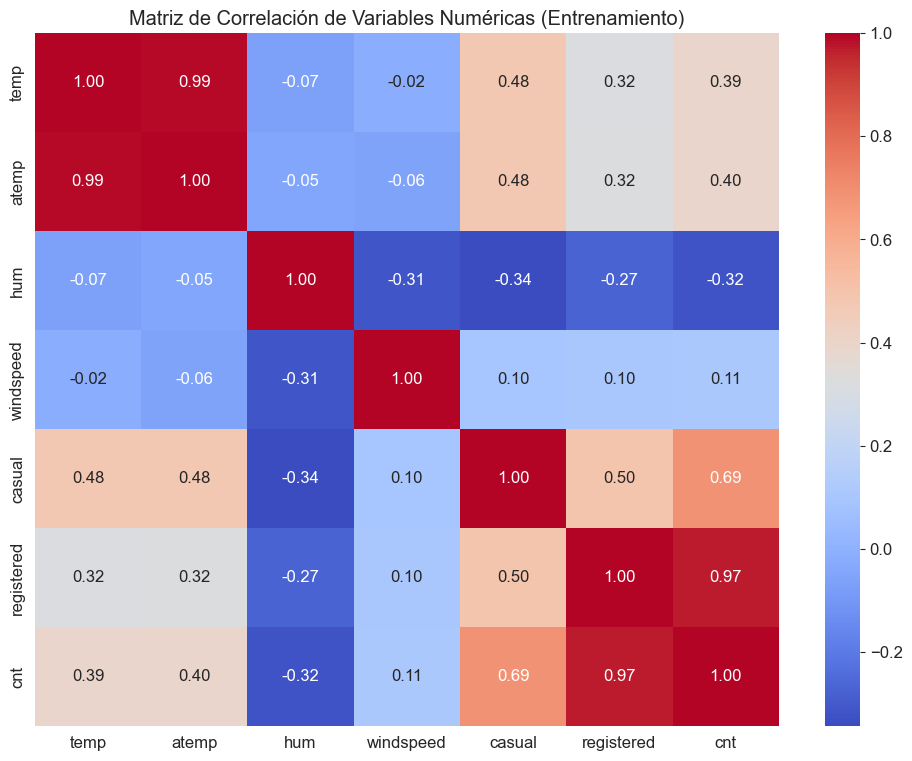

In [10]:
# 2. Matriz de Correlación
print("\nGenerando heatmap de correlación...")
plt.figure(figsize=(12, 9))
numerical_cols = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
corr_matrix = train_df[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Variables Numéricas (Entrenamiento)')
plt.show()


Generando gráficos de distribución de la variable objetivo...


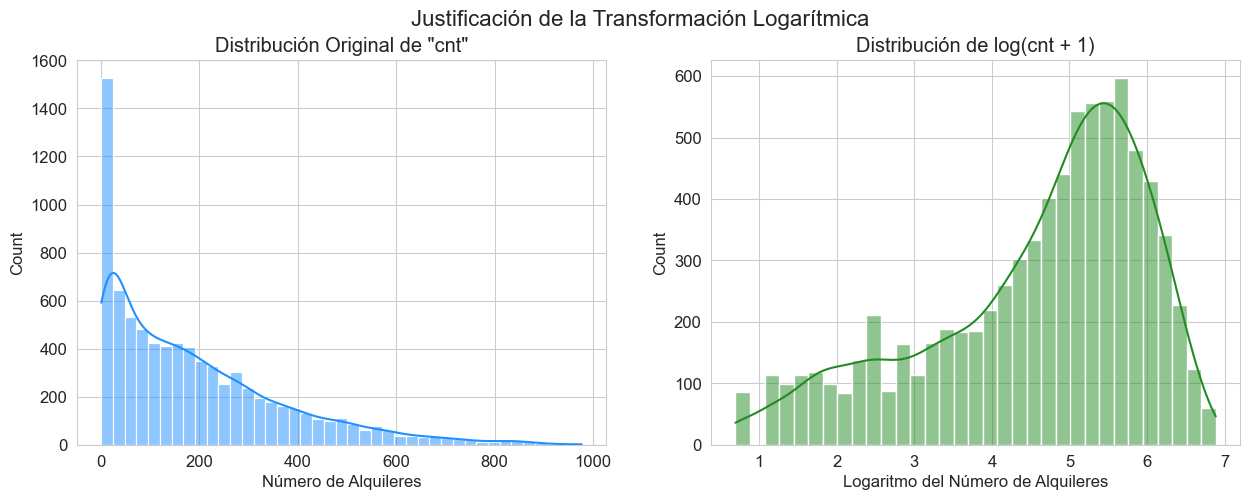

Se observa que la transformación logarítmica hace la distribución mucho más simétrica, parecida a una normal.


In [11]:
# 3. Distribución de 'count' y 'log(count + 1)'
print("\nGenerando gráficos de distribución de la variable objetivo...")
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(train_df['cnt'], kde=True, ax=axes[0], color='dodgerblue')
axes[0].set_title('Distribución Original de "cnt"')
axes[0].set_xlabel('Número de Alquileres')

sns.histplot(np.log1p(train_df['cnt']), kde=True, ax=axes[1], color='forestgreen')
axes[1].set_title('Distribución de log(cnt + 1)')
axes[1].set_xlabel('Logaritmo del Número de Alquileres')
plt.suptitle('Justificación de la Transformación Logarítmica', fontsize=16)
plt.show()
print("Se observa que la transformación logarítmica hace la distribución mucho más simétrica, parecida a una normal.")




Generando visualizaciones requeridas...


C:\Users\kripi\AppData\Local\Temp\ipykernel_3040\2824969227.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=train_df, x='hr', y='cnt', color='skyblue', ci=None)


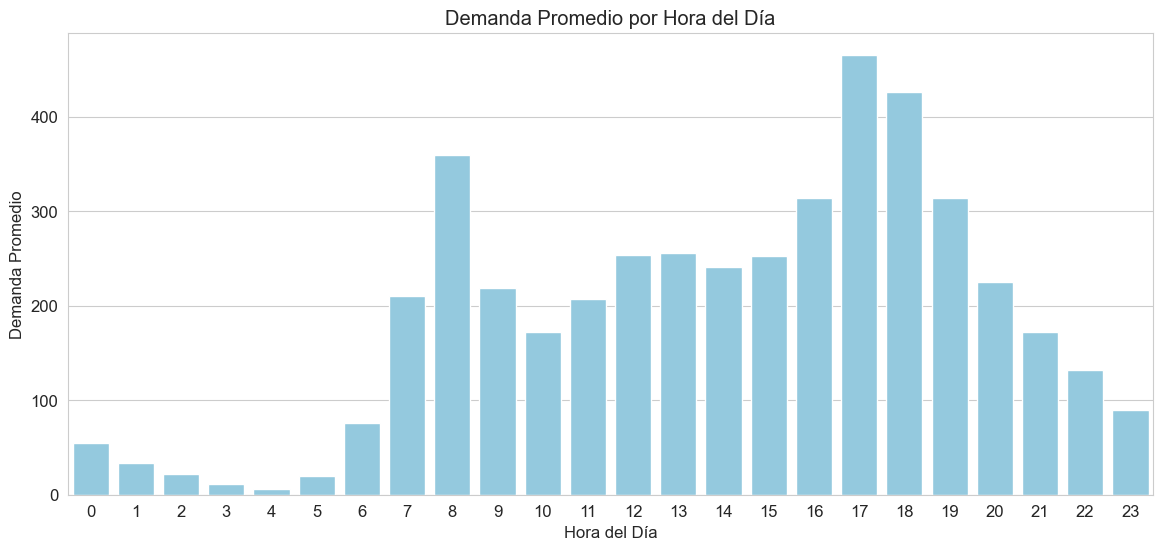

In [12]:
# 4. Visualizaciones Adicionales
print("\nGenerando visualizaciones requeridas...")
# Demanda promedio por hora
plt.figure(figsize=(14, 6))
sns.barplot(data=train_df, x='hr', y='cnt', color='skyblue', ci=None)
plt.title('Demanda Promedio por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Demanda Promedio')
plt.show()


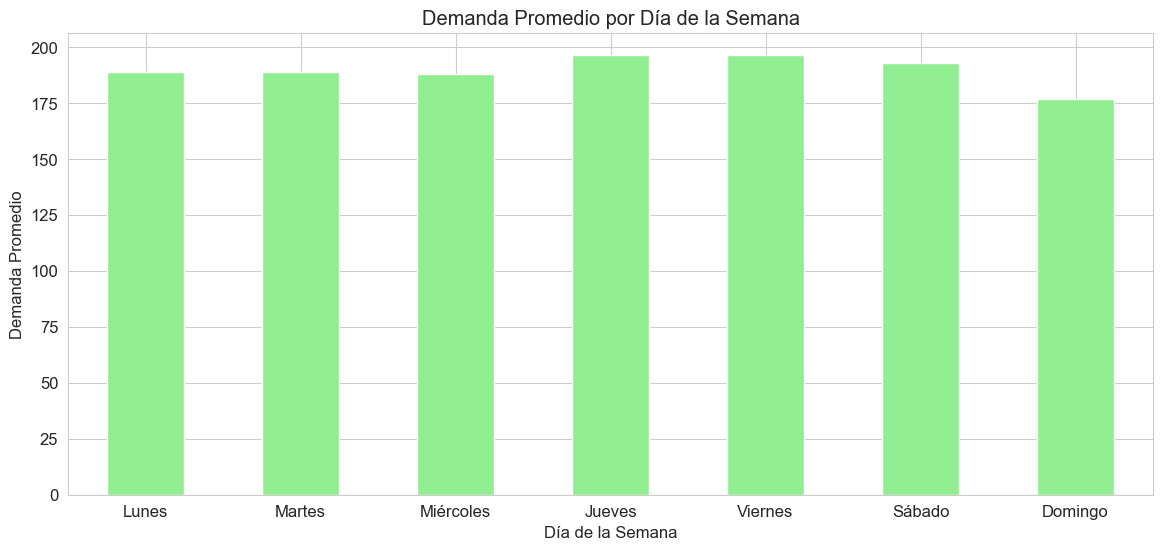

In [13]:
# Demanda promedio por día de la semana
weekday_map = {0: 'Lunes', 1: 'Martes', 2: 'Miércoles', 3: 'Jueves', 4: 'Viernes', 5: 'Sábado', 6: 'Domingo'}
avg_demand_weekday = train_df.groupby('day_of_week')['cnt'].mean().rename(index=weekday_map)
avg_demand_weekday = avg_demand_weekday.reindex(list(weekday_map.values()))

plt.figure(figsize=(14, 6))
avg_demand_weekday.plot(kind='bar', color='lightgreen', rot=0)
plt.title('Demanda Promedio por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Demanda Promedio')
plt.show()

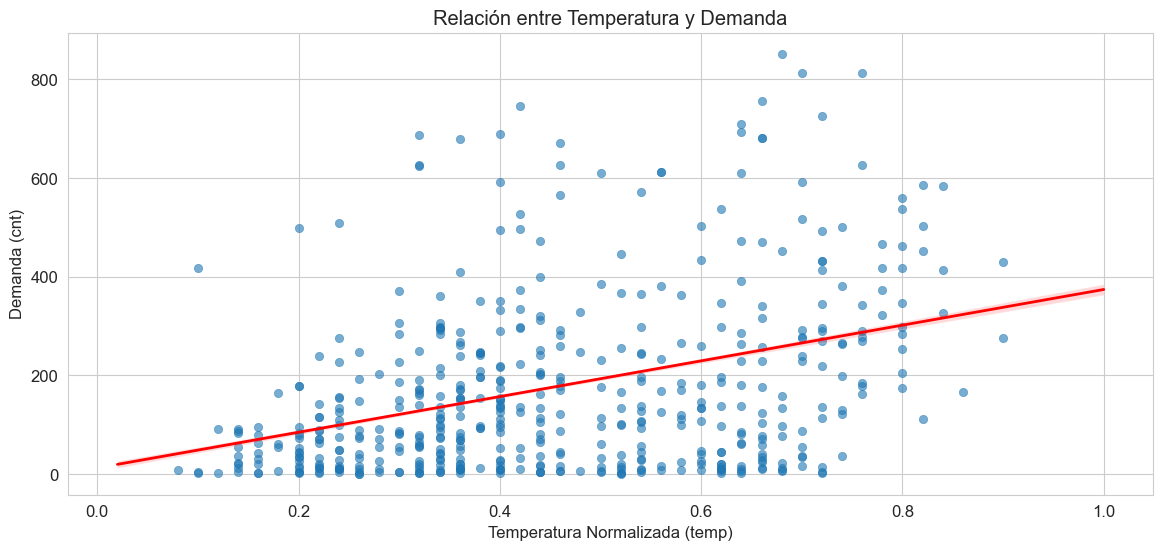

In [14]:
# Relación entre temperatura y demanda
plt.figure(figsize=(14, 6))
sns.scatterplot(data=train_df.sample(500), x='temp', y='cnt', alpha=0.6, ec=None)
sns.regplot(data=train_df, x='temp', y='cnt', scatter=False, color='red', line_kws={'linewidth': 2})
plt.title('Relación entre Temperatura y Demanda')
plt.xlabel('Temperatura Normalizada (temp)')
plt.ylabel('Demanda (cnt)')
plt.show()

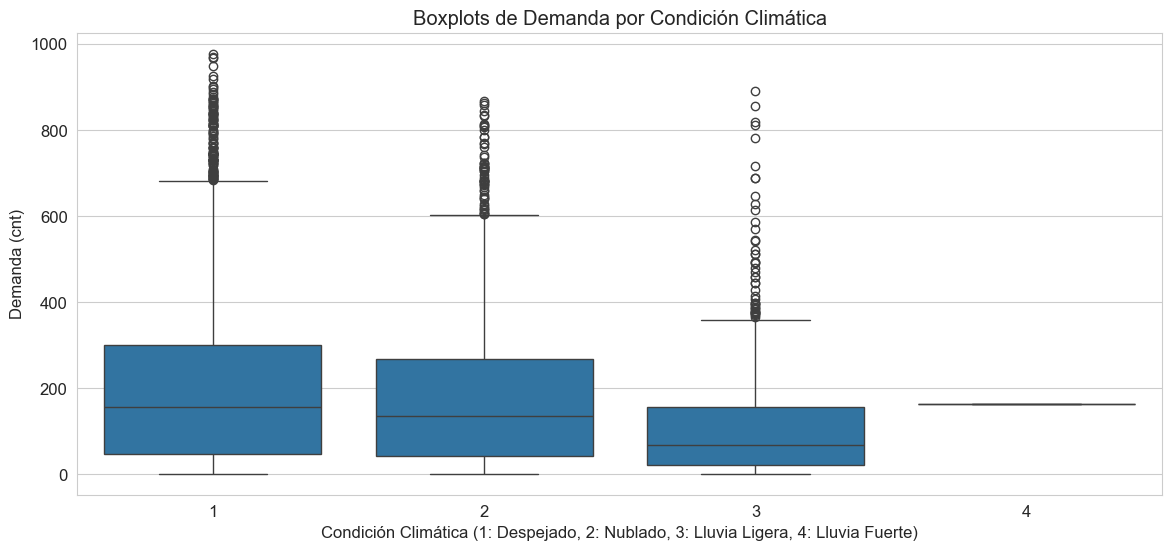

In [15]:
# Boxplots de demanda por condición climática
plt.figure(figsize=(14, 6))
sns.boxplot(data=train_df, x='weathersit', y='cnt')
plt.title('Boxplots de Demanda por Condición Climática')
plt.xlabel('Condición Climática (1: Despejado, 2: Nublado, 3: Lluvia Ligera, 4: Lluvia Fuerte)')
plt.ylabel('Demanda (cnt)')
plt.show()
print("\n")


In [16]:
# --- d) Preparación de Datos ---
print("--- d) Preparando los datos para el modelamiento... ---")
# 1. Identificar valores faltantes o anómalos
print("Valores Faltantes por Columna:")
print(df.isnull().sum())
print("No se encontraron valores faltantes.")


--- d) Preparando los datos para el modelamiento... ---
Valores Faltantes por Columna:
instant          0
dteday           0
season           0
yr               0
mnth             0
hr               0
holiday          0
weekday          0
workingday       0
weathersit       0
temp             0
atemp            0
hum              0
windspeed        0
casual           0
registered       0
cnt              0
day_of_week      0
is_weekend       0
hour_category    0
is_rush_hour     0
log_cnt          0
day              0
dtype: int64
No se encontraron valores faltantes.


In [17]:
# Documentación de valores anómalos o redundantes:
# - 'atemp' tiene una correlación de 0.99 con 'temp'. Es redundante y puede eliminarse.
# - 'casual' + 'registered' = 'cnt'. Estas dos columnas son una fuga de datos ('data leakage')
#   y no deben usarse como características para predecir 'cnt'.
# - La columna 'instant' es solo un índice y no aporta información.

# 2. Aplicar transformación logarítmica a la variable objetivo
print("\nAplicando transformación logarítmica a 'cnt'...")
train_df['cnt_log'] = np.log1p(train_df['cnt'])
val_df['cnt_log'] = np.log1p(val_df['cnt'])
test_df['cnt_log'] = np.log1p(test_df['cnt'])


Aplicando transformación logarítmica a 'cnt'...


In [22]:
# 3. Normalizar variables numéricas
print("Normalizando variables numéricas...")
# Seleccionar las columnas a normalizar
numeric_features_to_scale = ['temp', 'hum', 'windspeed']

# Crear el objeto StandardScaler
scaler = StandardScaler()

# Ajustar el scaler SÓLO con los datos de entrenamiento
scaler.fit(train_df[numeric_features_to_scale])

# Aplicar la transformación a todos los conjuntos de datos
train_df[numeric_features_to_scale] = scaler.transform(train_df[numeric_features_to_scale])
val_df[numeric_features_to_scale] = scaler.transform(val_df[numeric_features_to_scale])
test_df[numeric_features_to_scale] = scaler.transform(test_df[numeric_features_to_scale])

print("Variables normalizadas. Mostrando las primeras 5 filas del set de entrenamiento:")
display(train_df[['temp', 'hum', 'windspeed']].head())

Normalizando variables numéricas...
Variables normalizadas. Mostrando las primeras 5 filas del set de entrenamiento:


,temp,hum,windspeed
0,-1.270476,0.984349,-1.543684
1,-1.372131,0.933451,-1.543684
2,-1.372131,0.933451,-1.543684
3,-1.270476,0.678959,-1.543684
4,-1.270476,0.678959,-1.543684


In [23]:
# ============================================================================
# 2. REGRESIÓN LINEAL BASE
# ============================================================================

print("="*80)
print("2. REGRESIÓN LINEAL BASE")
print("="*80)

# --- a) Modelo Inicial (Solo variables originales) ---
print("\n--- a) Modelo Inicial (Variables Originales) ---\n")

# Definir variables originales (excluyendo atemp por ahora, lo analizaremos después)
original_features = ['season', 'holiday', 'workingday', 'weathersit', 
                     'temp', 'hum', 'windspeed']

# Preparar datos
X_train_orig = train_df[original_features]
y_train = train_df['cnt_log']
X_val_orig = val_df[original_features]
y_val = val_df['cnt_log']

# Entrenar modelo
modelo_base = LinearRegression()
modelo_base.fit(X_train_orig, y_train)

# Hacer predicciones
y_pred_train_base = modelo_base.predict(X_train_orig)
y_pred_val_base = modelo_base.predict(X_val_orig)

# Calcular métricas en escala logarítmica
mse_base = mean_squared_error(y_val, y_pred_val_base)
rmse_base = np.sqrt(mse_base)
mae_base = mean_absolute_error(y_val, y_pred_val_base)
r2_base = r2_score(y_val, y_pred_val_base)

print("Métricas en Validación (escala logarítmica):")
print(f"  MSE:  {mse_base:.4f}")
print(f"  RMSE: {rmse_base:.4f}")
print(f"  MAE:  {mae_base:.4f}")
print(f"  R²:   {r2_base:.4f}")


2. REGRESIÓN LINEAL BASE

--- a) Modelo Inicial (Variables Originales) ---

Métricas en Validación (escala logarítmica):
  MSE:  1.5098
  RMSE: 1.2288
  MAE:  0.9676
  R²:   0.2335


In [24]:
# Interpretar coeficientes
coef_base_df = pd.DataFrame({
    'Variable': original_features,
    'Coeficiente': modelo_base.coef_
}).sort_values('Coeficiente', key=abs, ascending=False)

print("\nCoeficientes del Modelo (ordenados por importancia):")
print(coef_base_df.to_string(index=False))
print(f"\nIntercepto: {modelo_base.intercept_:.4f}")

print("\nInterpretación de los 3 coeficientes más importantes:")
for i, row in coef_base_df.head(3).iterrows():
    var = row['Variable']
    coef = row['Coeficiente']
    print(f"  • {var}: {coef:.4f}")
    if coef > 0:
        print(f"    Por cada aumento de 1 unidad en {var}, log(count) aumenta {coef:.4f}")
    else:
        print(f"    Por cada aumento de 1 unidad en {var}, log(count) disminuye {abs(coef):.4f}")




Coeficientes del Modelo (ordenados por importancia):
  Variable  Coeficiente
       hum    -0.516719
      temp     0.440919
    season     0.216962
workingday    -0.129155
   holiday    -0.117875
weathersit     0.112191
 windspeed     0.066204

Intercepto: 3.9647

Interpretación de los 3 coeficientes más importantes:
  • hum: -0.5167
    Por cada aumento de 1 unidad en hum, log(count) disminuye 0.5167
  • temp: 0.4409
    Por cada aumento de 1 unidad en temp, log(count) aumenta 0.4409
  • season: 0.2170
    Por cada aumento de 1 unidad en season, log(count) aumenta 0.2170


In [26]:
# --- b) Modelo Mejorado (Con características temporales) ---
print("\n\n--- b) Modelo Mejorado (Con Características Temporales) ---\n")

# Convertir hour_category a variables dummy
train_df_encoded = pd.get_dummies(train_df, columns=['hour_category'], drop_first=True)
val_df_encoded = pd.get_dummies(val_df, columns=['hour_category'], drop_first=True)

# Definir todas las características
enhanced_features = ['season', 'holiday', 'workingday', 'weathersit', 
                     'temp', 'hum', 'windspeed',
                     'hr', 'day_of_week', 'mnth', 'yr',
                     'is_weekend', 'is_rush_hour'] + \
                    [col for col in train_df_encoded.columns if 'hour_category_' in col]

# Preparar datos
X_train_enh = train_df_encoded[enhanced_features]
X_val_enh = val_df_encoded[enhanced_features]

# Entrenar modelo mejorado
modelo_mejorado = LinearRegression()
modelo_mejorado.fit(X_train_enh, y_train)

# Hacer predicciones
y_pred_train_enh = modelo_mejorado.predict(X_train_enh)
y_pred_val_enh = modelo_mejorado.predict(X_val_enh)

# Calcular métricas
mse_enh = mean_squared_error(y_val, y_pred_val_enh)
rmse_enh = np.sqrt(mse_enh)
mae_enh = mean_absolute_error(y_val, y_pred_val_enh)
r2_enh = r2_score(y_val, y_pred_val_enh)

print("Métricas en Validación (escala logarítmica):")
print(f"  MSE:  {mse_enh:.4f}")
print(f"  RMSE: {rmse_enh:.4f}")
print(f"  MAE:  {mae_enh:.4f}")
print(f"  R²:   {r2_enh:.4f}")



--- b) Modelo Mejorado (Con Características Temporales) ---

Métricas en Validación (escala logarítmica):
  MSE:  0.4337
  RMSE: 0.6586
  MAE:  0.4935
  R²:   0.7798


In [27]:
# Comparación
print("\nComparación con Modelo Base:")
print(f"  Mejora en RMSE: {(rmse_base - rmse_enh)/rmse_base*100:.2f}%")
print(f"  Mejora en MAE:  {(mae_base - mae_enh)/mae_base*100:.2f}%")
print(f"  Mejora en R²:   {(r2_enh - r2_base)/r2_base*100:.2f}%")



Comparación con Modelo Base:
  Mejora en RMSE: 46.40%
  Mejora en MAE:  49.00%
  Mejora en R²:   233.93%


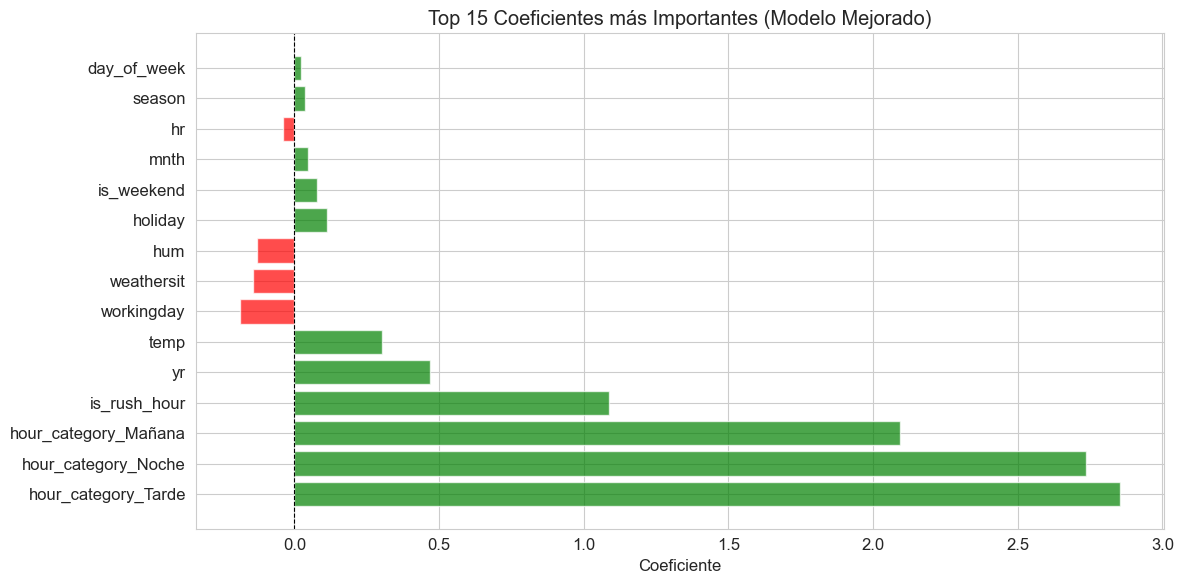



Análisis de Multicolinealidad (VIF) entre temp y atemp:
Variable        VIF
    temp 381.248132
   atemp 381.248132

Interpretación:
  • VIF > 10: Multicolinealidad alta (problemática)
  • VIF > 5:  Multicolinealidad moderada
  • VIF < 5:  Multicolinealidad baja
  ⚠ Se detecta multicolinealidad alta entre temp y atemp
    Recomendación: Eliminar una de estas variables


In [31]:
# Gráfico de importancia de coeficientes
coef_enh_df = pd.DataFrame({
    'Variable': enhanced_features,
    'Coeficiente': modelo_mejorado.coef_
}).sort_values('Coeficiente', key=abs, ascending=False).head(15)

plt.figure(figsize=(12, 6))
colors = ['green' if x > 0 else 'red' for x in coef_enh_df['Coeficiente']]
plt.barh(coef_enh_df['Variable'], coef_enh_df['Coeficiente'], color=colors, alpha=0.7)
plt.xlabel('Coeficiente')
plt.title('Top 15 Coeficientes más Importantes (Modelo Mejorado)')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

# Análisis VIF para multicolinealidad entre temp y atemp
print("\n\nAnálisis de Multicolinealidad (VIF) entre temp y atemp:")
# Crear dataframe temporal con temp y atemp sin normalizar para VIF
vif_data = pd.DataFrame()
# Usamos datos originales antes de normalizar
vif_features = df[df['day'].between(1, 14)][['temp', 'atemp']]
vif_data['Variable'] = ['temp', 'atemp']
vif_data['VIF'] = [variance_inflation_factor(vif_features.values, i) 
                   for i in range(len(vif_features.columns))]
print(vif_data.to_string(index=False))
print("\nInterpretación:")
print("  • VIF > 10: Multicolinealidad alta (problemática)")
print("  • VIF > 5:  Multicolinealidad moderada")
print("  • VIF < 5:  Multicolinealidad baja")
if vif_data['VIF'].max() > 10:
    print("  ⚠ Se detecta multicolinealidad alta entre temp y atemp")
    print("    Recomendación: Eliminar una de estas variables")

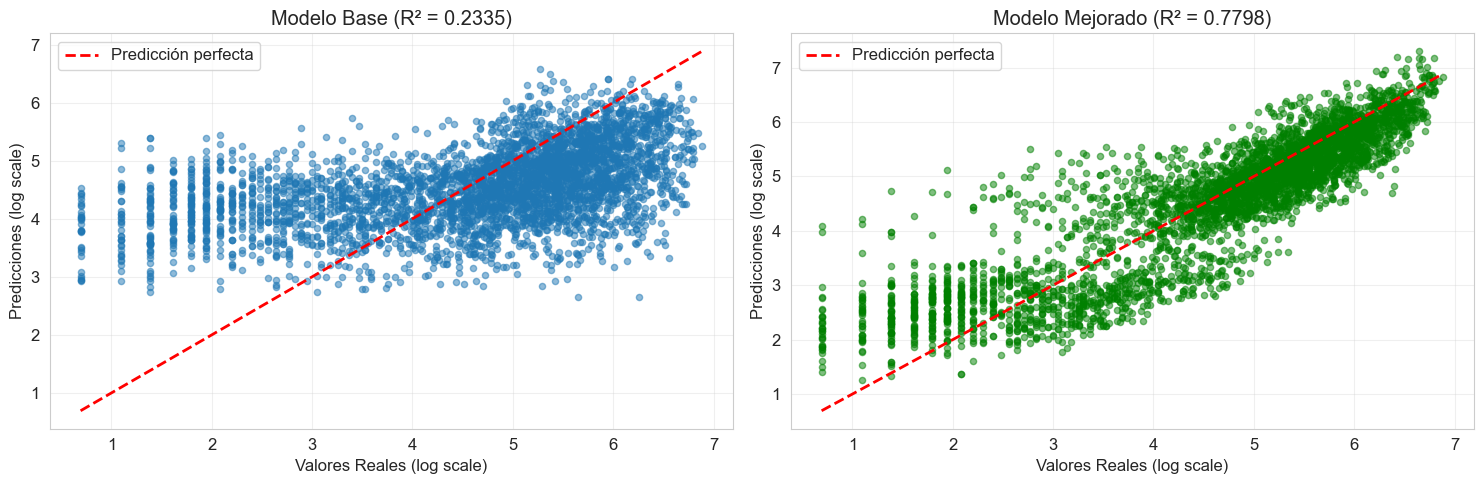

In [30]:
# Gráfico de predicciones vs valores reales
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Modelo Base
axes[0].scatter(y_val, y_pred_val_base, alpha=0.5, s=20)
axes[0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 
             'r--', lw=2, label='Predicción perfecta')
axes[0].set_xlabel('Valores Reales (log scale)')
axes[0].set_ylabel('Predicciones (log scale)')
axes[0].set_title(f'Modelo Base (R² = {r2_base:.4f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Modelo Mejorado
axes[1].scatter(y_val, y_pred_val_enh, alpha=0.5, s=20, color='green')
axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 
             'r--', lw=2, label='Predicción perfecta')
axes[1].set_xlabel('Valores Reales (log scale)')
axes[1].set_ylabel('Predicciones (log scale)')
axes[1].set_title(f'Modelo Mejorado (R² = {r2_enh:.4f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# ============================================================================
# 3. REGULARIZACIÓN: RIDGE Y LASSO
# ============================================================================

print("\n" + "="*80)
print("3. REGULARIZACIÓN: RIDGE Y LASSO")
print("="*80)

# Combinamos train y validation para el proceso de CV
train_val_df = pd.concat([train_df_encoded, val_df_encoded], axis=0).reset_index(drop=True)
X_train_val = train_val_df[enhanced_features]
y_train_val = train_val_df['cnt_log']

# Configurar TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
alphas = np.logspace(-3, 3, 50)  # 50 valores entre 10^-3 y 10^3

# --- a) Implementación de Ridge ---
print("\n--- a) Regresión Ridge ---\n")

# Almacenar resultados
ridge_scores = []
ridge_coefs = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    fold_scores = []
    
    for train_idx, val_idx in tscv.split(X_train_val):
        X_tr, X_va = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
        y_tr, y_va = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
        
        ridge.fit(X_tr, y_tr)
        y_pred = ridge.predict(X_va)
        score = r2_score(y_va, y_pred)
        fold_scores.append(score)
    
    ridge_scores.append(np.mean(fold_scores))
    
    # Entrenar con todos los datos para obtener coeficientes
    ridge.fit(X_train_val, y_train_val)
    ridge_coefs.append(ridge.coef_)

# Encontrar alpha óptimo
best_alpha_ridge = alphas[np.argmax(ridge_scores)]
best_score_ridge = max(ridge_scores)

print(f"Alpha óptimo: {best_alpha_ridge:.4f}")
print(f"R² promedio en CV: {best_score_ridge:.4f}")


3. REGULARIZACIÓN: RIDGE Y LASSO

--- a) Regresión Ridge ---

Alpha óptimo: 6.2506
R² promedio en CV: 0.6809



Métricas en Validación:
  MSE:  0.4309
  RMSE: 0.6565
  MAE:  0.4910
  R²:   0.7812


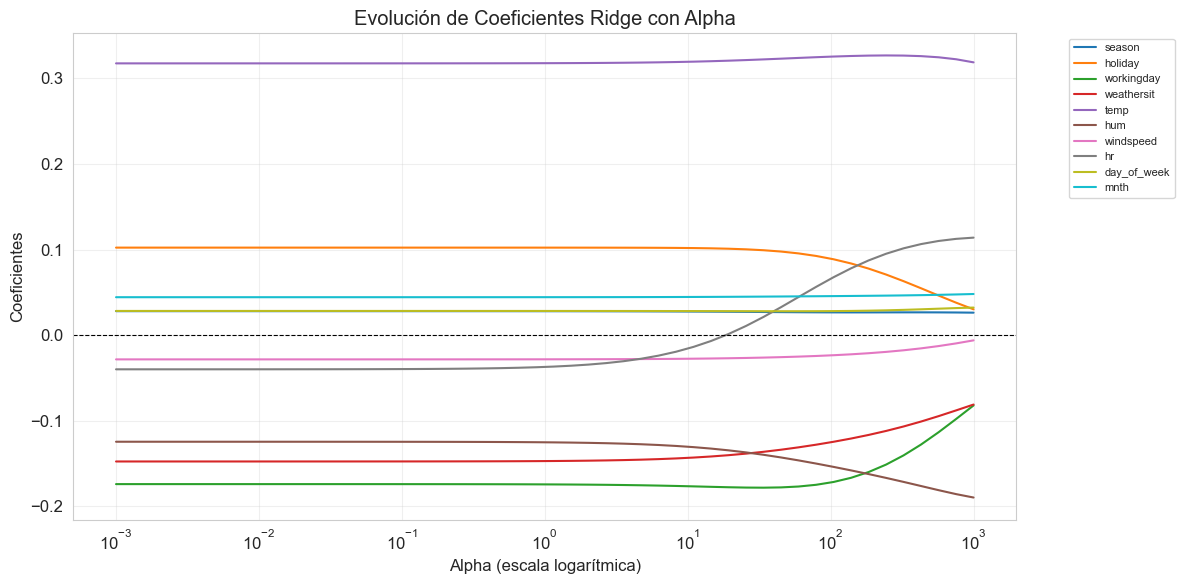

In [33]:
# Entrenar modelo final con alpha óptimo
ridge_final = Ridge(alpha=best_alpha_ridge)
ridge_final.fit(X_train_val, y_train_val)

# Evaluar en conjunto de validación original
y_pred_ridge = ridge_final.predict(X_val_enh)
mse_ridge = mean_squared_error(y_val, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
mae_ridge = mean_absolute_error(y_val, y_pred_ridge)
r2_ridge = r2_score(y_val, y_pred_ridge)

print("\nMétricas en Validación:")
print(f"  MSE:  {mse_ridge:.4f}")
print(f"  RMSE: {rmse_ridge:.4f}")
print(f"  MAE:  {mae_ridge:.4f}")
print(f"  R²:   {r2_ridge:.4f}")

# Gráfico de coeficientes vs alpha
plt.figure(figsize=(12, 6))
ridge_coefs_array = np.array(ridge_coefs)
for i in range(min(10, ridge_coefs_array.shape[1])):  # Mostrar solo 10 características
    plt.plot(alphas, ridge_coefs_array[:, i], label=enhanced_features[i])
plt.xscale('log')
plt.xlabel('Alpha (escala logarítmica)')
plt.ylabel('Coeficientes')
plt.title('Evolución de Coeficientes Ridge con Alpha')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()